In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from math import sqrt
from warnings import catch_warnings, filterwarnings
import tqdm

from statsmodels.tsa.statespace.sarimax import SARIMAX
from pylab import rcParams

import xgboost as xgb
from fbprophet import Prophet

In [2]:
train_x = pd.read_csv("train_x.csv", parse_dates = ['timestamp'])
train_y = pd.read_csv("train_y.csv")

test_x = pd.read_csv("test_x.csv", parse_dates = ['timestamp'])
test_y = pd.read_csv("test_y.csv")

In [3]:
def train_test_split(data, percent_in_test):
    # splits data set into two arrays - train and test, based on the % to keep in test set
    num_to_test = len(data) - (round(len(data) * (percent_in_test / 100))) # convert % to float

    train = data[:num_to_test]
    test = data[num_to_test:]
    
    return train, test

In [4]:
train_x, eval_x = train_test_split(train_x, 15)
train_y, eval_y = train_test_split(train_y, 15)

In [26]:
train_x.head(1)

,timestamp,temperature,temperature_feel,humidity,wind_speed,weather_code,holiday_flag,weekend_flag,season
0,2015-01-04,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0


In [6]:
train_x.shape

(11842, 9)

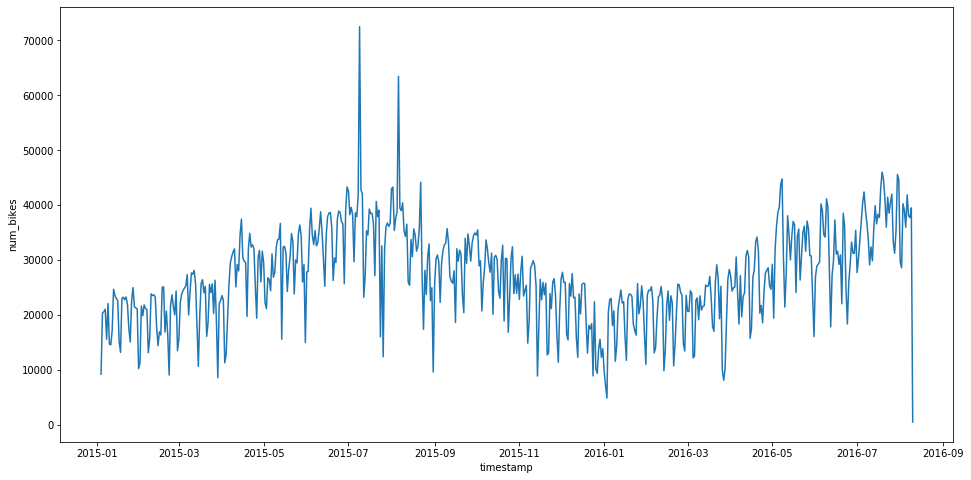

In [6]:
# group sales into daily view, so we get a neater view of trend
grouped_bikes = train_x[['timestamp']].copy() 
grouped_bikes['num_bikes'] = train_y['num_bikes'].copy()
grouped_bikes = pd.DataFrame(grouped_bikes.groupby(grouped_bikes['timestamp'].dt.date)['num_bikes'].sum())

# lineplot shows a bit of variance, the peaks will likely be weekends
plt.figure(figsize = (16,8))
sns.lineplot(x = grouped_bikes.index,
             y = grouped_bikes['num_bikes']);

### SARIMA

In [8]:
# SARIMA stands for seasonal autoregressive integrated moving average, and we need it over ARIMA because we have seasonality
# SARIMA requires multiple hyperparameters, which we will optimise by gridsearch
# There are three parameters shared with ARIMA: Autoregression, Difference and Moving Average
# There are four parameter unique to SARIMA - seasonal versions of each of the above, and the number of intervals in a single
    # season of your seasonal dataset

In [7]:
def sarima_forecast(train_dataset, configuration):
    # we will be running this function many times with different configurations, to find the best configuration
    order, seasonal_order, trend = configuration
        
    # instantiate
    model = SARIMAX(train_dataset, order = order, seasonal_order = seasonal_order, trend = trend,
                    enforce_stationarity = False, enforce_invertibility = False) # more robust, and allows 0 as hyperparameters
    fitted_model = model.fit(disp = False) # don't print convergence messages
    
    # the arguments are indices of when to start and stop predicting. If ranges are supplied, like here, it defaults to first
    # value of argument 1, and last value of argument 2 (so we're applying predict() to the whole dataset)
    result = fitted_model.predict(len(train_dataset), len(train_dataset)) 
    
    return result    

In [29]:
def walk_forward_validate(dataset, what_percent_in_test, config):
    # predicts value 1 in the test dataset by using the whole train dataset. Then adds the true value 1 to the train dataset
    # and predicts value 2, and so on
#     print("walk forward validation beginning")

    predictions = []
    train, test = train_test_split(dataset, what_percent_in_test) # split into training and test
        
    history = [datapoint for datapoint in train['num_bikes']] # convert our target variable into array
    test = [datapoint for datapoint in test['num_bikes']] # same for test
    
    for datapoint in range(len(test)): # keep as a generator, as time series can get long
        with catch_warnings():
            filterwarnings("ignore")
            pred = sarima_forecast(history, config) # predict next soonest value
            predictions.append(pred)
            history.append(test[datapoint]) # append the true value to our historical datapoints, so we maintain accuracy
            
    rmse = sqrt(mean_squared_error(test, predictions)) # root-mean-squared-error is a standard assessment of the difference
                                                       # between two lists of datapoints
    return rmse

In [13]:
def sarima_configs(seasonal=[0]):
    # creates all the possible configurations for SARIMA hyperparameters. You can supply values higher than 2, but this is
    # rarely useful
    models = list()
    # define config lists
    p_params = [0, 1, 2]
    d_params = [0, 1]
    q_params = [0, 1, 2]
    t_params = ['n','c','t','ct']
    P_params = [0, 1, 2]
    D_params = [0, 1]
    Q_params = [0, 1, 2]
    m_params = seasonal
    # create config instances
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p,d,q), (P,D,Q,m), t]
                                    models.append(cfg)
    return models

In [14]:
configs = sarima_configs()

In [15]:
configs[1]

[(0, 0, 0), (0, 0, 1, 0), 'n']

In [43]:
for config in configs[:1]:
    try:
#         assessment = walk_forward_validate(train_y, 15, config)
        print(str(config)+f" producted an rmse of "+str(round(assessment,2)))
    except Exception as e:
        print(e)

[(0, 0, 0), (0, 0, 0, 0), 'n'] producted an rmse of 1880.11


In [41]:
type(config)

list

In [36]:
round(assessment,2)

1880.11

### XGBoost

In [ ]:
# xgboost (eXtreme Gradient Boosting) is an ensembling model, with gradient boosting. It is both fast and reliable.
# gradient boosting means that new models are created that predict the residuals of prior models.

In [7]:
# xgboost doesn't like datetime datatypes, so we'll pull all the components out into new columns
def create_date_components(dataframe):
    
    dataframe['hour'] = dataframe['timestamp'].dt.hour
    dataframe['dayofweek'] = dataframe['timestamp'].dt.dayofweek
    dataframe['quarter'] = dataframe['timestamp'].dt.quarter
    dataframe['month'] = dataframe['timestamp'].dt.month
    dataframe['year'] = dataframe['timestamp'].dt.year
    dataframe['dayofyear'] = dataframe['timestamp'].dt.dayofyear
    dataframe['dayofmonth'] = dataframe['timestamp'].dt.day
    dataframe['weekofyear'] = dataframe['timestamp'].dt.weekofyear
    
    dataframe = dataframe.set_index('timestamp')
    
    return dataframe

In [8]:
xgboost_train_x = create_date_components(train_x.copy()) # has to be .copy() so we don't add columns inplace
xgboost_eval_x = create_date_components(eval_x.copy())

In [9]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(xgboost_train_x, train_y, verbose=False) # Change verbose to True if you want to see it train

[10:39:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [10]:
preds = reg.predict(xgboost_eval_x) # make predictions
xgboost_result = sqrt(mean_squared_error(eval_y, preds)) # evaluate performance

print(f"xgboost RMSE is {round(xgboost_result, 2)}")
# this is a LOT better than SARIMA, though that one does need more tuning

xgboost RMSE is 345.5


### Prophet

In [ ]:
# Prophet is facebook's forecasting algorithm, and is used internally a lot. It is extremely powerful, and simple to implement

In [11]:
mod = Prophet()

In [12]:
# prophet has a slightly different way of adding regressors - they can't just be supplied unexpectedly
additional_regressors = ['temperature', 'temperature_feel', 'humidity','wind_speed', 'weather_code', 'holiday_flag', 
                         'weekend_flag', 'season']

for regressor in additional_regressors:
    mod.add_regressor(regressor)

In [13]:
# the algorithm also expects your date and outcome variables to be named specifically
def column_renamer(dataset):
    dataset = dataset.rename({'timestamp':'ds','num_bikes':'y'}, axis = 1)
    return dataset

In [14]:
train = train_x.merge(train_y, left_index = True, right_index = True)
train = column_renamer(train)

In [15]:
mod.fit(train)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [16]:
eval_x = column_renamer(eval_x)

In [20]:
preds = mod.predict(eval_x)['yhat']

In [22]:
prophet_result = sqrt(mean_squared_error(eval_y, preds)) # evaluate performance

print(f"prophet RMSE is {round(prophet_result, 2)}")

prophet RMSE is 730.55
